Load graphs

In [1]:
import os
from omegaconf import OmegaConf
from LayoutGKN.utils import load_pickle
cfg = OmegaConf.load("../cfg.yaml")
graphs = load_pickle(os.path.join(cfg.path_data, "rplan", "nx_graphs.pkl"))
ids = [G.graph["pid"] for G in graphs]
print(len(graphs))

80788


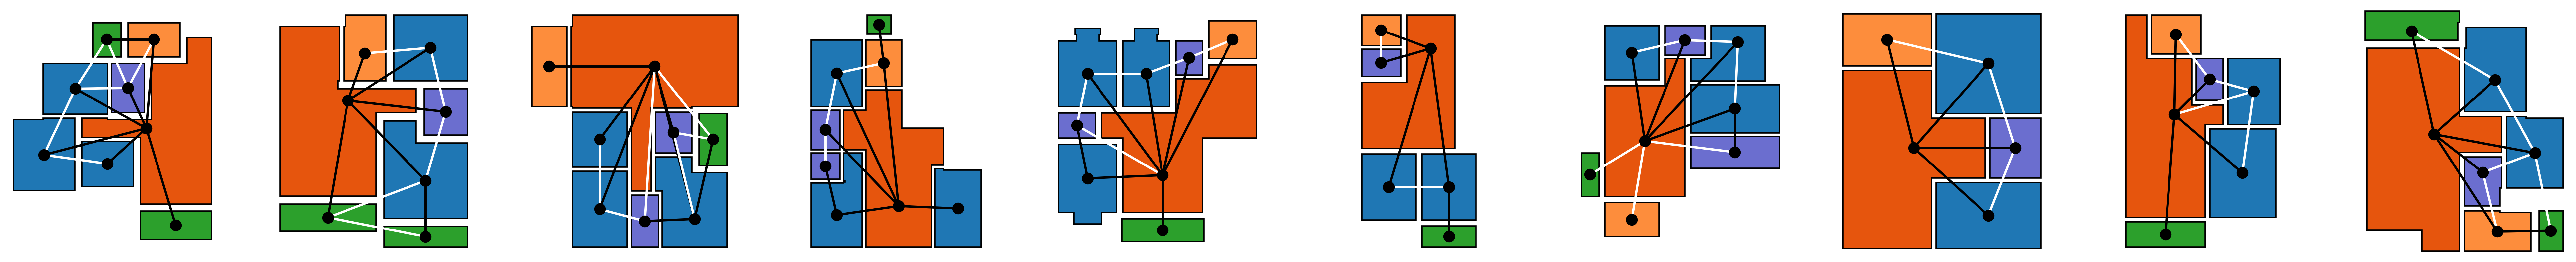

In [2]:
import matplotlib.pyplot as plt
from LayoutGKN.plot import draw_graph
n, fs = 10, 10
fig, axs = plt.subplots(1,n,figsize=(n*fs,fs)); axs = axs.flatten()
for ax, G in zip(axs, graphs):
    ax.axis("equal"); ax.axis('off')
    draw_graph(ax, G, fs=fs, s=fs*6, w=fs/2, lw=fs/3)

Check connectivity graphs

In [3]:
import networkx as nx

def check_connectedness(G):
    """Checks whether an access graph is connected w.r.t. access.
    It checks, thus, whether each room could be reached from all others."""
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    # only add "door" edges to new graph
    edges = [(u, v) for u, v, d in G.edges(data=True) if d["connectivity"]==1]
    H.add_edges_from(edges)
    return len(list(nx.connected_components(H))) == 1

In [5]:
from tqdm import tqdm
ids_valid = []
for G in tqdm(graphs):
    if check_connectedness(G): ids_valid.append(G.graph["pid"])
ids_invalid = list(set(ids).difference(set(ids_valid)))

100%|██████████| 80788/80788 [00:00<00:00, 112151.00it/s]


In [6]:
print(len(ids_valid))
print(len(ids_invalid))

72389
8399


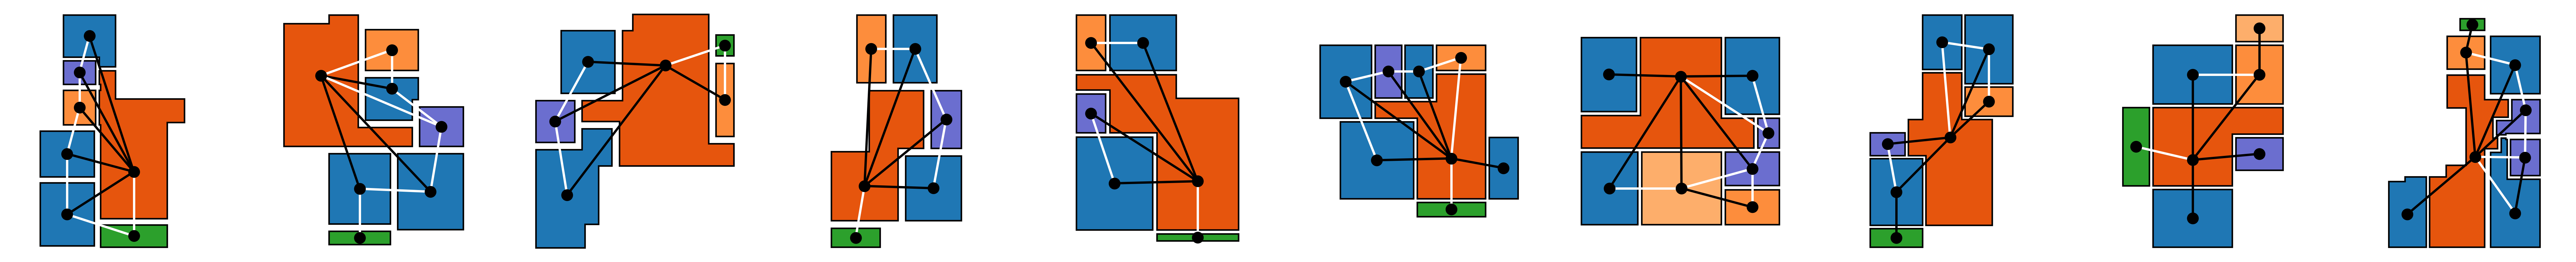

In [7]:
n, fs = 10, 10
fig, axs = plt.subplots(1,n,figsize=(n*fs,fs)); axs = axs.flatten()
for ax, pid in zip(axs, ids_invalid):
    G = graphs[ids.index(pid)]
    ax.axis("equal"); ax.axis('off')
    draw_graph(ax, G, fs=fs, s=fs*6, w=fs/2, lw=fs/3)

Make training, validation, test split (0.7, 0.2, 0.1) at RANDOM

In [8]:
import random
from torch_geometric.utils import from_networkx

# DO NOT CHANGE SEED = 42
def split_ids(ids, seed=42):
    """Splits IDs into train, val, test (0.7, 0.2, 0.1)."""
    random.seed(seed); random.shuffle(ids)
    n = len(ids); a, b = int(n*0.7), int(n*0.9)
    return ids[:a], ids[a:b], ids[b:]


def nx_to_pyg(G):
    """Converts networkx graph to Pytorch Geometric graph."""
    G = G.copy()
    G = remove_attributes_from_graph(G, node_attr=["polygon"])
    return from_networkx(G)


def remove_attributes_from_graph(graph, node_attr=['polygon'], edge_attr=[]):
    """Removes attribute(s) from graph"""
    for attr in node_attr:
        for n in graph.nodes(): # delete irrelevant node features
            try: del graph.nodes[n][attr]
            except: pass
    for attr in edge_attr:
        for u, v in graph.edges(): # delete irrelevant edge features
            try: del graph.edges[u, v][attr]
            except: pass
    return graph

In [9]:
import torch
dir_save = os.path.join(cfg.path_data, "rplan")
# splits IDs into train, val, test
train_ids, val_ids, test_ids = split_ids(ids_valid)
train_set, val_set = set(train_ids), set(val_ids)
# aggregates list of PyG graphs for training, validation, and test
pyg_graphs_train, pyg_graphs_val, pyg_graphs_test = [], [], []
for pid in tqdm(ids_valid):
    G = graphs[ids.index(pid)]
    G_pyg = nx_to_pyg(G)
    if pid in train_set: pyg_graphs_train.append(G_pyg)
    elif pid in val_set: pyg_graphs_val.append(G_pyg)
    else: pyg_graphs_test.append(G_pyg)
    torch.save((train_ids, pyg_graphs_train), os.path.join(dir_save, "pyg_graphs_train.pt"))
    torch.save((val_ids, pyg_graphs_val), os.path.join(dir_save, "pyg_graphs_val.pt"))
    torch.save((test_ids, pyg_graphs_test), os.path.join(dir_save, "pyg_graphs_test.pt"))

  0%|          | 0/72389 [00:00<?, ?it/s]/home/casper/PycharmProjects/LayoutGKN/.venv/lib/python3.10/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  data_dict[key] = torch.as_tensor(value)
  1%|          | 432/72389 [00:14<40:10, 29.86it/s]  


KeyboardInterrupt: 